# Practice notebook for hypothesis tests using NHANES data

This notebook will give you the opportunity to perform some hypothesis tests with the NHANES data that are similar to
what was done in the week 3 case study notebook.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

* We use z-tests with proportions and t-test with means. That's the rule that we should follow.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import numpy as np

da = pd.read_csv("../DataFiles/nhanes_2015_2016.csv")

## Question 1

Conduct a hypothesis test (at the 0.05 level) for the null hypothesis that the proportion of women who smoke is equal to the proportion of men who smoke.

In [2]:
da.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')

In [3]:
print(da['SMQ020'].value_counts(), '\n', da['RIAGENDR'].value_counts())

2    3406
1    2319
9       8
7       2
Name: SMQ020, dtype: int64 
 2    2976
1    2759
Name: RIAGENDR, dtype: int64


* RIAGENDR = (1 == Male & 2 == Female) Small value counts we can attribute to null for 10 values for 9 & 7
* SMQ020 = (1 == Yes & 2 == No)

In [4]:
da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})  # np.nan represents a missing value
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

In [5]:
da_1 = da[['SMQ020x', 'RIAGENDRx']].dropna()
display(pd.crosstab(da_1['SMQ020x'], da_1['RIAGENDRx']))
da_1 = pd.crosstab(da_1['SMQ020x'], da_1['RIAGENDRx'])
print(da_1.index, da_1.columns)

RIAGENDRx,Female,Male
SMQ020x,,
No,2066,1340
Yes,906,1413


Index(['No', 'Yes'], dtype='object', name='SMQ020x') Index(['Female', 'Male'], dtype='object', name='RIAGENDRx')


In [6]:
# Need percentages for each as well as size of each for further hypothesis confirmation
da_1.loc['Yes', 'Female'], da_1['Female'].sum()
female_smoke_prop, female_total = da_1.loc['Yes', 'Female'] / da_1['Female'].sum(), da_1['Female'].sum()
male_smoke_prop, male_total = da_1.loc['Yes', 'Male'] / da_1['Male'].sum(), da_1['Male'].sum()
print("Perentage of female smokers : {} and total found females in dataset : {}".format(female_smoke_prop, female_total))
print("Perentage of male smokers : {} and total found females in dataset : {}".format(male_smoke_prop, male_total))

Perentage of female smokers : 0.30484522207267833 and total found females in dataset : 2972
Perentage of male smokers : 0.5132582637123139 and total found females in dataset : 2753


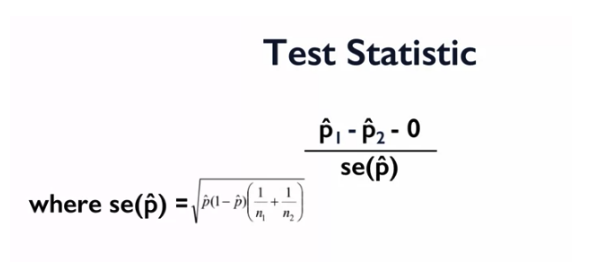

* phat for two proportions is the combined percentage of the parameter of interest / total test subject in comparison
* Ex : So if sample one was 5 / 12 and sample two was 8 / 23, p-hat would be 13 / 35.

In [7]:
da_1.sum(), da_1.sum().sum() # default will sum each column in the dataframe 
                            # and return sum for a series return .. which we can sum again in our case

(RIAGENDRx
 Female    2972
 Male      2753
 dtype: int64,
 5725)

In [8]:
# phat translates more or less for two percentages as combined percentage for interest parameter (total smokers)
# Total yes versus total observed count
phat = da_1.loc['Yes', :].sum() / da_1.sum().sum()
standard_error_phat = np.sqrt(phat * (1 - phat) * ((1 / male_total) + (1 / female_total)))
z_prop_test_stat = (female_smoke_prop - male_smoke_prop) / standard_error_phat
phat, standard_error_phat, z_prop_test_stat

(0.4050655021834061, 0.01298546309757376, -16.049719603652488)

In [9]:
# Alternatively We can just pass the successess and total counts to the proportions_ztest for a zstat and pval for percentage comparison
display(da_1)
print(da_1.loc['Yes', 'Female'])

RIAGENDRx,Female,Male
SMQ020x,,
No,2066,1340
Yes,906,1413


906


In [10]:
# https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
# count = number of successess in nob trials
# nobs = number of total trials each
zstat, pval = proportions_ztest(count = [da_1.loc['Yes', 'Female'], da_1.loc['Yes', 'Male']], 
                                nobs = [da_1.loc[:, 'Female'].sum(), da_1.loc[:, 'Male'].sum()],
                               alternative = 'two-sided')
zstat, pval

(-16.049719603652488, 5.742288777302776e-58)

__Q1a.__ Write 1-2 sentences explaining the substance of your findings to someone who does not know anything about statistical hypothesis tests.

* Our extremely small pval and test statistic state that the null hypothesis of proportion of women who smoke being the same as males can be rejected
* Our two-tailed test shows females have a far smaller proportional percentage and do not have a shared proportion for men who smoke

__Q1b.__ Construct three 95% confidence intervals: one for the proportion of women who smoke, one for the proportion of men who smoke, and one for the difference in the rates of smoking between women and men.

In [11]:
# default alpha for common 95%

female_smok_conf_95 = sm.stats.proportion_confint(da_1.loc['Yes', 'Female'], female_total, alpha=0.05)
print("95% Confidence Interval for Proportion of Females who smoke : {}, {}".format(female_smok_conf_95[0], female_smok_conf_95[1]))
male_smok_conf_95 = sm.stats.proportion_confint(da_1.loc['Yes', 'Male'], male_total, alpha=0.05)
print("95% Confidence Interval for Proportion of Males who smoke : {}, {}".format(male_smok_conf_95[0], male_smok_conf_95[1]))



# difference in the rates of smoking between women and men
lwb_diff_smo = (female_smoke_prop - male_smoke_prop) - (1.96 * np.sqrt((female_smoke_prop * (1 - female_smoke_prop) / female_total) + 
                                                                      (male_smoke_prop * (1 - male_smoke_prop) / male_total)))

hwb_diff_smo = (female_smoke_prop - male_smoke_prop) + (1.96 * np.sqrt((female_smoke_prop * (1 - female_smoke_prop) / female_total) + 
                                                                      (male_smoke_prop * (1 - male_smoke_prop) / male_total)))


print("Difference in rates of smoking between women and men : {}% lower for females to {}% lower for females".format(
round(lwb_diff_smo * 100, 2), round(hwb_diff_smo * 100, 2)))

95% Confidence Interval for Proportion of Females who smoke : 0.2882949879861214, 0.32139545615923526
95% Confidence Interval for Proportion of Males who smoke : 0.49458749263718593, 0.5319290347874418
Difference in rates of smoking between women and men : -23.34% lower for females to -18.35% lower for females


__Q1c.__ Comment on any ways in which the confidence intervals that you found in part b reinforce, contradict, or add support to the hypothesis test conducted in part a.

* Using a 95% confidence interval to estimate our proportion of females and males who smoke add further evidence to above when we rejected our null hypothesis of the two proportions being equal
* Furthermore, the difference in rates show females averaging about a 20% difference in proportion of the population who smoked

## Question 2

Partition the population into two groups based on whether a person has graduated college or not, using the educational attainment variable [DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2).  Then conduct a test of the null hypothesis that the average heights (in centimeters) of the two groups are equal.  Next, convert the heights from centimeters to inches, and conduct a test of the null hypothesis that the average heights (in inches) of the two groups are equal.

In [12]:
display(da['DMDEDUC2'].value_counts())
college_grad = da.loc[da['DMDEDUC2'] == 5, ['BMXHT', 'DMDEDUC2']].dropna()
na_college_grad = da.loc[da['DMDEDUC2'] != 5, ['BMXHT', 'DMDEDUC2']].dropna()
(len(da), len(college_grad), len(na_college_grad), len(college_grad) + len(na_college_grad))

4.0    1621
5.0    1366
3.0    1186
1.0     655
2.0     643
9.0       3
Name: DMDEDUC2, dtype: int64

(5735, 1355, 4062, 5417)

In [13]:
# Generate mean, stdv and sample size for test stat calc
mean_inches_cgrad = college_grad['BMXHT'].mean()
mean_inches_nacgrad = na_college_grad['BMXHT'].mean()
std_inches_cgrad = college_grad['BMXHT'].std()
std_inches_nacgrad = na_college_grad['BMXHT'].std()

# Validate education conditional setting for each dataframe
display(college_grad['DMDEDUC2'].value_counts())
display(na_college_grad['DMDEDUC2'].value_counts())
print(mean_inches_cgrad, mean_inches_nacgrad, std_inches_cgrad, std_inches_nacgrad)


5.0    1355
Name: DMDEDUC2, dtype: int64

4.0    1603
3.0    1176
1.0     646
2.0     634
9.0       3
Name: DMDEDUC2, dtype: int64

167.85535055350562 165.46395864106336 9.705432880946816 10.172963714064156


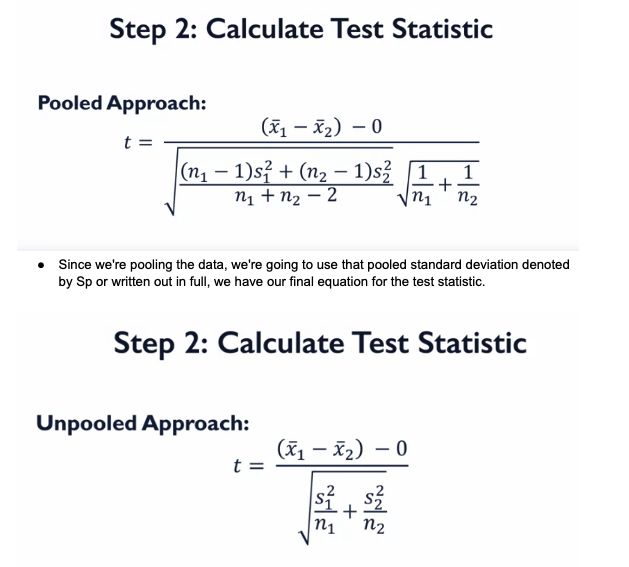
* Null hypothesis would suggest a pooled approach
* https://infrrr.com/means/difference-in-means-hypothesis-test-calculator
    * A great way to check your work for a two sample t-test

In [19]:
mu1, n1, s1 = college_grad['BMXHT'].mean(), len(college_grad['BMXHT']), college_grad['BMXHT'].std()
print("Mean of College grad Height cms : {}, Total observed values for strata : {}, Standard Deviation : {}".format(
                        mu1, n1, s1))

print('\n')

mu2, n2, s2 = na_college_grad['BMXHT'].mean(), len(na_college_grad['BMXHT']), na_college_grad['BMXHT'].std()
print("Mean of College grad Height cms : {}, Total observed values for strata : {}, Standard Deviation : {}".format(
                        mu2, n2, s2))

Mean of College grad Height cms : 167.85535055350562, Total observed values for strata : 1355, Standard Deviation : 9.705432880946816


Mean of College grad Height cms : 165.46395864106336, Total observed values for strata : 4062, Standard Deviation : 10.172963714064156


In [36]:
denominator_1 = np.sqrt(((n1 - 1) * (s1 ** 2) + (n2 - 1) * (s2 ** 2)) / ((n1 + n2) - 2))
denominator_2 = np.sqrt((1/n1) + (1/n2))
two_mean_test_stat = (mu1 - mu2) / (denominator_1 * denominator_2)
print("Our two_mean_test_stat matching the methods output below is : {}".format(two_mean_test_stat))
print("Our left side of the equation all operations under left sided square root is : {}".format(denominator_1))
print("Our right side of the equation all operations under right sided square root is : {}".format(denominator_2))
print(np.sqrt(547685.4343 / 5415)) # Correct left side denominator output

Our two_mean_test_stat matching the methods output below is : 7.578706943765888
Our left side of the equation all operations under left sided square root is : 10.058097276445721
Our right side of the equation all operations under right sided square root is : 0.03137182694416783
10.056951715226674


* This is originally how I performed (see below) and had gotten this test statistic (0.213). However, we can see above and from the test details below that this is incorrect and is 7.57

In [37]:
den_1_2 = np.sqrt(((n1 - 1) * s1 ** 2) + ((n2 - 1) * s2 ** 2) / ((n1 + n2) - 2))
den_2_2 = np.sqrt((1 / n1) + (1 / n2))
two_mean_test_stat_2 = (mu1 - mu2 - 0) / (den_1_2 * den_2_2)
two_mean_test_stat_2
print("Our two_mean_test_stat matching the methods output below is : {}".format(two_mean_test_stat_2))
print("Our left side of the equation all operations under left sided square root is : {}".format(den_1_2))
print("Our right side of the equation all operations under right sided square root is : {}".format(den_2_2))
print(np.sqrt(547685.4343 / 5415))

Our two_mean_test_stat matching the methods output below is : 0.21338043820173508
Our left side of the equation all operations under left sided square root is : 357.2369253361676
Our right side of the equation all operations under right sided square root is : 0.03137182694416783
10.056951715226674


#### Differences in Manual Calculation Above of test statistic for test proportions 
* difference in calculation is on the left side (see different results)
* ... a bit unsure of what's not working but can also just use the stats method or follow the syntax for the top manual calculation
* The steps below produce the output we want prior to being divided by the two totals (minus 2) and then taking the square root


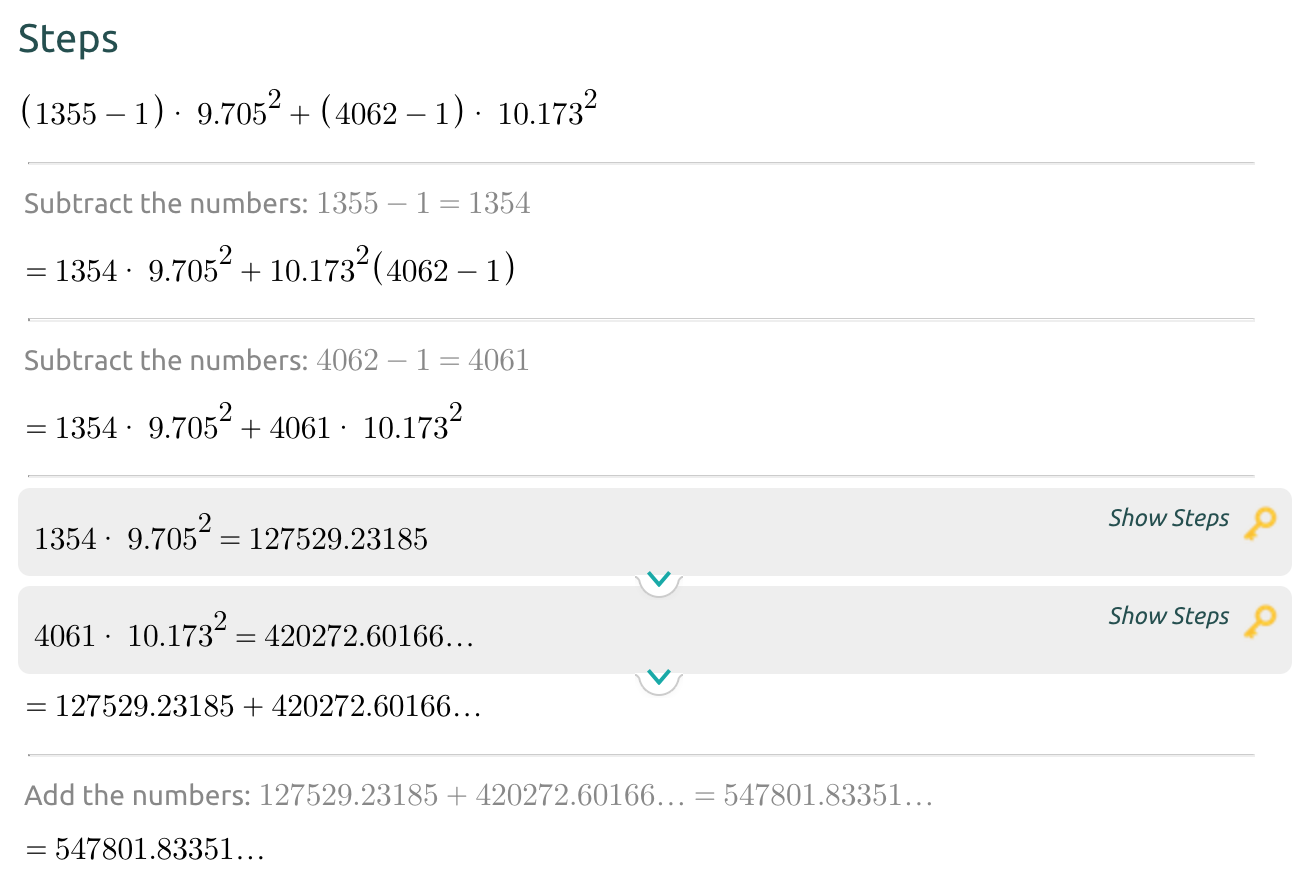

In [16]:
sm.stats.ztest(college_grad['BMXHT'], na_college_grad['BMXHT']) # Using ZTest

(7.578706943765076, 3.4901585776605263e-14)

In [17]:
sm.stats.ttest_ind(college_grad['BMXHT'], na_college_grad['BMXHT']) # Ttest should be used

(7.578706943765076, 4.081324042778962e-14, 5415.0)

In [18]:
cgrad_statsW = sm.stats.DescrStatsW(college_grad['BMXHT'])
nacgrad_statsW = sm.stats.DescrStatsW(na_college_grad['BMXHT'])

print("pooled t-stat and p-value: ", sm.stats.CompareMeans(cgrad_statsW, nacgrad_statsW).ztest_ind(usevar='pooled'))
print("unpooled t-stat and p-value: ", sm.stats.CompareMeans(cgrad_statsW, nacgrad_statsW).ztest_ind(usevar='unequal'))

p_value_pooled = sm.stats.CompareMeans(cgrad_statsW, nacgrad_statsW).ztest_ind(usevar='pooled')[1]
# transform from float to string
p_value_pooled_scientific_exponent = str(p_value_pooled)
exponent = p_value_pooled_scientific_exponent[p_value_pooled_scientific_exponent.index('-'):][1:]
#p_value_pooled, type(p_value_pooled_scientific_exponent), exponent
print("Pooled P-value without scientific notation : {:.{}f}".format(p_value_pooled, exponent))


pooled t-stat and p-value:  (7.578706943765076, 3.4901585776605263e-14)
unpooled t-stat and p-value:  (7.758931901880965, 8.56476203963662e-15)
Pooled P-value without scientific notation : 0.00000000000003


__Q2a.__ Based on the analysis performed here, are you confident that people who graduated from college have a different average height compared to people who did not graduate from college?

* With the associated t statistic, we have an extremely small p-value (see above w/o scientific notation) that would provide sufficient evidence (at 95% or 99% confidence and above) to reject the null hypothesis of college graudates having a shared average height compared to people who did not graduate from college.

__Q2b:__ How do the results obtained using the heights expressed in inches compare to the results obtained using the heights expressed in centimeters?

In [19]:
college_grad['BMXHTin'] = college_grad['BMXHT'].apply(lambda x: x/2.54)
na_college_grad['BMXHTin'] = na_college_grad['BMXHT'].apply(lambda x: x/2.54)
display(college_grad[['BMXHTin', 'BMXHT']].head()) # looks good!

(sm.stats.ttest_ind(college_grad['BMXHTin'], na_college_grad['BMXHTin']), 
sm.stats.ztest(college_grad['BMXHTin'], na_college_grad['BMXHTin']))

,BMXHTin,BMXHT
0,72.637795,184.5
3,63.346457,160.9
10,69.566929,176.7
13,64.606299,164.1
14,72.362205,183.8


((7.578706943765084, 4.0813240427786826e-14, 5415.0),
 (7.578706943764969, 3.4901585776634256e-14))

* Our transformation to inches shows the same relationship!

## Question 3

Conduct a hypothesis test of the null hypothesis that the average BMI for men between 30 and 40 is equal to the average BMI for men between 50 and 60.  Then carry out this test again after log transforming the BMI values.
* https://www.geeksforgeeks.org/log-and-natural-logarithmic-value-of-a-column-in-pandas-python/

In [43]:
da_subset = da[['BMXBMI', 'RIDAGEYR', 'RIAGENDR']].dropna()
da_30_40_males = da_subset.loc[(da_subset['RIAGENDR'] == 1) & (da_subset['RIDAGEYR'] >= 30) & 
                               (da_subset['RIDAGEYR'] <= 40), :]

da_50_60_males = da_subset.loc[(da_subset['RIAGENDR'] == 1) & (da_subset['RIDAGEYR'] >= 50) & 
                               (da_subset['RIDAGEYR'] <= 60), :]

# First five rows of each to get a look at some values and our age/gender contional setting worked
display(pd.concat([da_30_40_males.head(), da_50_60_males.head()]))

,BMXBMI,RIDAGEYR,RIAGENDR
64,27.0,30,1
68,31.1,35,1
70,30.7,40,1
99,22.9,37,1
110,26.0,37,1
1,30.8,53,1
9,33.6,56,1
24,25.0,56,1
28,30.8,51,1
32,24.4,56,1


In [44]:
# Create log Transformation column for each subset
da_30_40_males['BMI_log'] = da_30_40_males['BMXBMI'].apply(lambda x: np.log(x))
da_50_60_males['BMI_log'] = da_50_60_males['BMXBMI'].apply(lambda x: np.log(x))
display(pd.concat([da_30_40_males.head(), da_50_60_males.head()]))

/var/folders/r8/mmfd5rgj7v51_80zhnq8v9zc0000gn/T/ipykernel_19389/1017189523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_30_40_males['BMI_log'] = da_30_40_males['BMXBMI'].apply(lambda x: np.log(x))
/var/folders/r8/mmfd5rgj7v51_80zhnq8v9zc0000gn/T/ipykernel_19389/1017189523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_50_60_males['BMI_log'] = da_50_60_males['BMXBMI'].apply(lambda x: np.log(x))


,BMXBMI,RIDAGEYR,RIAGENDR,BMI_log
64,27.0,30,1,3.295837
68,31.1,35,1,3.437208
70,30.7,40,1,3.424263
99,22.9,37,1,3.131137
110,26.0,37,1,3.258097
1,30.8,53,1,3.427515
9,33.6,56,1,3.514526
24,25.0,56,1,3.218876
28,30.8,51,1,3.427515
32,24.4,56,1,3.194583


In [47]:
test_bmi_normal_ttest = sm.stats.ttest_ind(da_30_40_males['BMXBMI'], da_50_60_males['BMXBMI'])
test_bmi_log_ttest = sm.stats.ttest_ind(da_30_40_males['BMI_log'], da_50_60_males['BMI_log'])

print("Our test statistic for mean comparison of bmi (without log transformation : {})".format(test_bmi_normal_ttest[0]))
print("Our p-value for mean comparison of bmi (without log transformation : {})".format(test_bmi_normal_ttest[1]), '\n')
print("Our p-value is signicantly above our confidence level (5%) threshold and thus we don't have statisicial evidence to reject null", '\n')

print("Our test statistic for mean comparison of bmi (with  transformation : {})".format(test_bmi_log_ttest[0]))
print("Our p-value for mean comparison of bmi (with transformation : {})".format(test_bmi_log_ttest[1]), '\n')
print("Our p-value is signicantly above our confidence level (5%) threshold and thus we don't have statisicial evidence to reject null")



Our test statistic for mean comparison of bmi (without log transformation : 0.898400801675522)
Our p-value for mean comparison of bmi (without log transformation : 0.36919303123271296) 

Our p-value is signicantly above our confidence level (5%) threshold and thus we don't have statisicial evidence to reject null 

Our test statistic for mean comparison of bmi (with  transformation : 0.7057844184100324)
Our p-value for mean comparison of bmi (with transformation : 0.4804902912676029) 

Our p-value is signicantly above our confidence level (5%) threshold and thus we don't have statisicial evidence to reject null


__Q3a.__ How would you characterize the evidence that mean BMI differs between these age bands, and how would you characterize the evidence that mean log BMI differs between these age bands?

* Each band shows similarity in their mean male bmi that we could not reject the null hypothesis of them being equal
* Furthermore, a log transformation only solidifes the similarity and produces an even higher p-value (fairly considerable) as well as lower t-statistic (standard deviations away)

## Question 4

Suppose we wish to compare the mean BMI between college graduates and people who have not graduated from college, focusing on women between the ages of 30 and 40.  First, consider the variance of BMI within each of these subpopulations using graphical techniques, and through the estimated subpopulation variances.  Then, calculate pooled and unpooled estimates of the standard error for the difference between the mean BMI in the two populations being compared.  Finally, test the null hypothesis that the two population means are equal, using each of the two different standard errors.

In [42]:
subset_4 = da[['BMXBMI', 'RIDAGEYR', 'RIAGENDR', 'DMDEDUC2']].dropna()
subset_4_females_cgrad = subset_4.loc[(subset_4['RIAGENDR'] == 2) & (subset_4['DMDEDUC2'] == 5)]
subset_4_females_nacgrad = subset_4.loc[(subset_4['RIAGENDR'] == 2) & (subset_4['DMDEDUC2'] != 5)]

## College grad determinations from above
# college_grad = da.loc[da['DMDEDUC2'] == 5, ['BMXHT', 'DMDEDUC2']].dropna()
# na_college_grad = da.loc[da['DMDEDUC2'] != 5, ['BMXHT', 'DMDEDUC2']].dropna()


In [43]:
# Total females (Gender 2 then subset on education value check. Values add up so should be good for two subsests)
subset_4['RIAGENDR'].value_counts(), subset_4_females_cgrad['RIAGENDR'].value_counts(), subset_4_females_nacgrad['RIAGENDR'].value_counts()

(2    2823
 1    2583
 Name: RIAGENDR, dtype: int64,
 2    709
 Name: RIAGENDR, dtype: int64,
 2    2114
 Name: RIAGENDR, dtype: int64)

In [46]:
# Now need to subset by age
subset_4_females_cgrad_30_40 = subset_4_females_cgrad.loc[(subset_4_females_cgrad['RIDAGEYR'] >= 30) & 
                                                    (subset_4_females_cgrad['RIDAGEYR'] <= 40)]

subset_4_females_nacgrad_30_40 = subset_4_females_nacgrad.loc[(subset_4_females_nacgrad['RIDAGEYR'] >= 30) & 
                                                    (subset_4_females_nacgrad['RIDAGEYR'] <= 40)]

display(pd.concat([subset_4_females_cgrad_30_40.head(), subset_4_females_nacgrad_30_40.head()]))

,BMXBMI,RIDAGEYR,RIAGENDR,DMDEDUC2
65,27.8,31,2,5.0
79,23.9,32,2,5.0
154,19.6,31,2,5.0
326,24.0,36,2,5.0
354,35.2,31,2,5.0
7,28.2,32,2,4.0
12,26.6,30,2,4.0
34,25.5,37,2,4.0
50,27.2,39,2,3.0
61,35.3,37,2,3.0


In [49]:
print(subset_4_females_cgrad_30_40.describe(), '\n\n', subset_4_females_nacgrad_30_40.describe())

           BMXBMI    RIDAGEYR  RIAGENDR  DMDEDUC2
count  171.000000  171.000000     171.0     171.0
mean    27.808187   34.543860       2.0       5.0
std      7.358264    3.339973       0.0       0.0
min     17.100000   30.000000       2.0       5.0
25%     22.750000   31.000000       2.0       5.0
50%     26.300000   34.000000       2.0       5.0
75%     31.150000   37.000000       2.0       5.0
max     62.700000   40.000000       2.0       5.0 

            BMXBMI   RIDAGEYR  RIAGENDR    DMDEDUC2
count  354.000000  354.00000     354.0  354.000000
mean    31.257345   34.99435       2.0    3.073446
std      8.256083    3.12714       0.0    1.085692
min     16.600000   30.00000       2.0    1.000000
25%     25.300000   32.00000       2.0    2.000000
50%     29.500000   35.00000       2.0    3.000000
75%     35.875000   37.75000       2.0    4.000000
max     60.900000   40.00000       2.0    4.000000


In [54]:
## Pooled and Un-pooled Manual
# Standard Deviation, mean, size needed

femMean_30_40cgrad, femMean_30_40nacgrad = subset_4_females_cgrad_30_40['BMXBMI'].mean(), subset_4_females_nacgrad_30_40['BMXBMI'].mean()
femStd_30_40cgrad, femStd_30_40nacgrad = subset_4_females_cgrad_30_40['BMXBMI'].std(), subset_4_females_nacgrad_30_40['BMXBMI'].std()
fem30_40cgrad_count, fem30_40nacgrad_count = len(subset_4_females_cgrad_30_40), len(subset_4_females_nacgrad_30_40)

left_t_pooled = np.sqrt(((fem30_40cgrad_count - 1) * (femStd_30_40cgrad ** 2) + (fem30_40nacgrad_count - 1) * (femStd_30_40nacgrad ** 2)) / (fem30_40cgrad_count + fem30_40nacgrad_count - 2))
right_t_pooled = np.sqrt((1 / fem30_40cgrad_count) + (1 / fem30_40nacgrad_count))
t_pooled_30_40 = (femMean_30_40cgrad - femMean_30_40nacgrad) / (left_t_pooled * right_t_pooled)
print(t_pooled_30_40)


denominator_1_fpooled = np.sqrt(((fem30_40cgrad_count - 1) * (femStd_30_40cgrad ** 2) + (fem30_40nacgrad_count - 1) * (femStd_30_40nacgrad ** 2)) / ((fem30_40cgrad_count + fem30_40nacgrad_count) - 2))
denominator_2_fpooled = np.sqrt((1/fem30_40cgrad_count) + (1/fem30_40nacgrad_count))
t_pooled_30_40_t_tstat = (femMean_30_40cgrad - femMean_30_40nacgrad) / (denominator_1_fpooled * denominator_2_fpooled)
t_pooled_30_40_t_tstat

-4.643908450956404


-4.643908450956404

In [47]:
cgrad_statsW_30_40 = sm.stats.DescrStatsW(subset_4_females_cgrad_30_40['BMXBMI'])
nacgrad_statsW_30_40 = sm.stats.DescrStatsW(subset_4_females_nacgrad_30_40['BMXBMI'])

print("pooled t-stat and p-value: ", sm.stats.CompareMeans(cgrad_statsW_30_40, nacgrad_statsW_30_40).ztest_ind(usevar='pooled'))
print("unpooled t-stat and p-value: ", sm.stats.CompareMeans(cgrad_statsW_30_40, nacgrad_statsW_30_40).ztest_ind(usevar='unequal'))



pooled t-stat and p-value:  (-4.643908450956429, 3.4187910067116e-06)
unpooled t-stat and p-value:  (-4.833662355599106, 1.3404386169203498e-06)


__Q4a.__ Comment on the strength of evidence against the null hypothesis that these two populations have equal mean BMI.

* We can see a mean difference when looking at our two subsets explained seen in the two counts above
* The subset of 30-40 is about ~525 of the 2800 total females for our subset
* When observing the hypothesis, we can see that our associated p-value with either tstat would be lower than a .05 confidence level and thus we'd reject for our means being the same

## Question 5

Conduct a test of the null hypothesis that the first and second diastolic blood pressure measurements within a subject have the same mean values.

In [58]:
da.head()
bpressure = da[['BPXSY1', 'BPXSY2']].dropna()
display(bpressure.describe())
print(sm.stats.ztest(bpressure['BPXSY1'], bpressure['BPXSY2'])) # prints test statistic, p-value
print(sm.stats.ttest_ind(bpressure['BPXSY1'], bpressure['BPXSY2'])) # prints test statistic, p-value, degrees of freedom

,BPXSY1,BPXSY2
count,5369.000000,5369.000000
mean,125.088471,124.413485
std,18.493801,18.191573
min,84.000000,84.000000
25%,112.000000,112.000000
50%,122.000000,122.000000
75%,134.000000,134.000000
max,236.000000,238.000000


(1.9065526348810609, 0.056578543590194645)
(1.9065526348810609, 0.05660521364967507, 10736.0)


__Q5a.__ Briefly describe your findings for an audience that is not familiar with statistical hypothesis testing.

* Depending on the alpha/significance to which we would conduct the test, we would state that the received P-value would detail that the means while not likely to have the same mean couldn't be rejected at that level. 
* However we would state that this value is certainly capable of rejecting the null at a slightly lower significance level .. say .1 or 90%